We start with looking at the data: it is now split in three target cathegories (classes): low, medium, and high grade at the final exam.

Original dataset size: 16
Augmented dataset size: 160


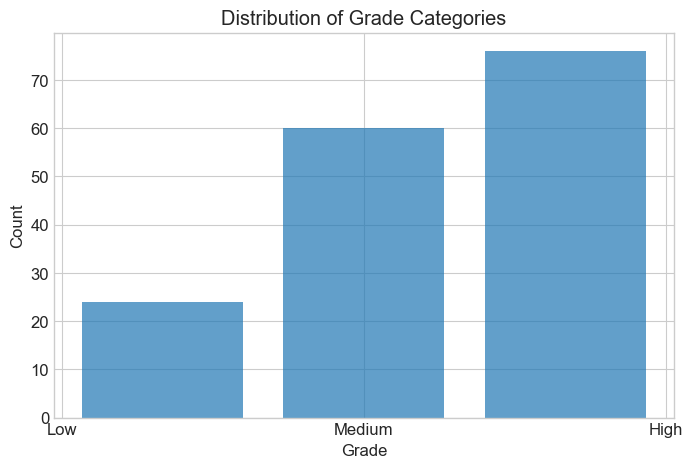

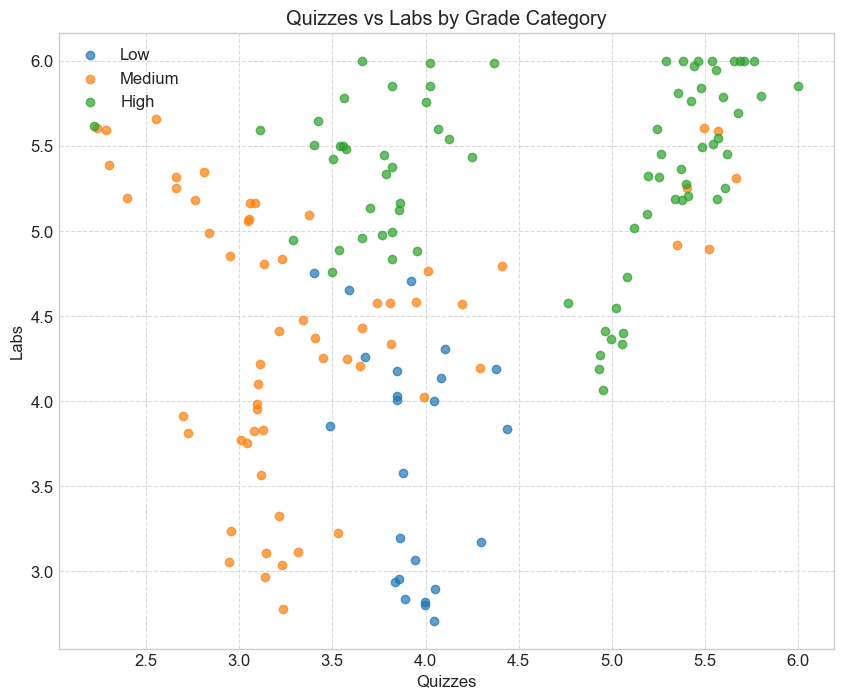

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Force matplotlib to show plots inline and not use interactive mode
from IPython import display
plt.ioff()  # Turn off interactive mode

# Set the style for better-looking plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 12

# 1. Create the dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Augmenting data by replicating and adding noise
np.random.seed(42)
augmented = []
for i in range(len(df)):
    row = df.iloc[i]
    for _ in range(10):  # Create 10 variations of each record
        noise = np.random.normal(0, 0.2, 3)  # Add Gaussian noise
        new_row = row + noise
        # Ensure values are within boundaries
        new_row = new_row.clip(2, 6)
        augmented.append(new_row)

# Create augmented DataFrame
df_aug = pd.DataFrame(augmented, columns=df.columns)
print(f"Original dataset size: {len(df)}")
print(f"Augmented dataset size: {len(df_aug)}")

# Create grade categories for multi-class classification
def grade_to_category(grade):
    if grade < 3.5:
        return 0  # 'Low'
    elif grade < 4.5:
        return 1  # 'Medium'
    else:
        return 2  # 'High'

# Apply the function to create categorical grades
df_aug['Grade_Category'] = df_aug['Final'].apply(grade_to_category)

# Define labels for visualization
grade_labels = ['Low', 'Medium', 'High']

# Visualize the distribution of grade categories
fig1 = plt.figure(figsize=(8, 5))
plt.hist(df_aug['Grade_Category'], bins=3, rwidth=0.8, alpha=0.7)
plt.xticks(range(3), grade_labels)
plt.title('Distribution of Grade Categories')
plt.xlabel('Grade')
plt.ylabel('Count')
# Explicitly display the figure in the notebook
display.display(fig1)
plt.close(fig1)  # Close the figure to free memory

# Visualize the data with respect to the features
fig2 = plt.figure(figsize=(10, 8))
for category in range(3):
    subset = df_aug[df_aug['Grade_Category'] == category]
    plt.scatter(subset['Quizzes'], subset['Labs'], label=grade_labels[category], alpha=0.7)
plt.title('Quizzes vs Labs by Grade Category')
plt.xlabel('Quizzes')
plt.ylabel('Labs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
# Explicitly display the figure
display.display(fig2)
plt.close(fig2)

We want to predict for every sample, the right assignment in one of the three classes, given the features Labs and Quizzes. 
We start with with logistic regression for many classes, using the One-vs-All approach (sigmoid for each of the three models). This corresponds to having three separate models, for each class: High vs High, Medium, Low; then Medium vs High, Medium, Low; and Low vs High, Medium Low. But we also run in parallel softmax regression. We will compare the resulting probabilities (sigmoid vs softmax).

In [9]:

X = df_aug[['Quizzes', 'Labs']].values
y = df_aug['Grade_Category'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class SoftmaxRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
    
    def softmax(self, z):
        shifted_z = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(shifted_z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_classes = len(np.unique(y))
        
        self.weights = np.random.randn(n_features, self.n_classes) * 0.01
        self.bias = np.zeros((1, self.n_classes))
        
        y_one_hot = np.zeros((n_samples, self.n_classes))
        y_one_hot[np.arange(n_samples), y] = 1
        
        for _ in range(self.epochs):
            linear_output = np.dot(X, self.weights) + self.bias
            y_pred = self.softmax(linear_output)
            
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y_one_hot))
            db = (1/n_samples) * np.sum(y_pred - y_one_hot, axis=0, keepdims=True)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def linear_predictor(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def predict_proba(self, X):
        linear_output = self.linear_predictor(X)
        return self.softmax(linear_output)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# Train the softmax model
model = SoftmaxRegression(learning_rate=0.1, epochs=1000)
model.fit(X_train_scaled, y_train)

# Select 3 samples
sample_indices = [0, 5, 10]  # Use just 3 samples
sample_data = []

for idx in sample_indices:
    # Get features
    quiz_scaled = X_test_scaled[idx, 0]
    lab_scaled = X_test_scaled[idx, 1]
    
    # Get true class
    true_class = y_test[idx]
    true_label = grade_labels[true_class]
    
    # For each class
    for class_idx, class_name in enumerate(grade_labels):
        # Calculate linear predictor manually for clarity
        w_quiz = model.weights[0, class_idx]
        w_lab = model.weights[1, class_idx]
        bias = model.bias[0, class_idx]
        
        # Linear predictor: w1*x1 + w2*x2 + b
        linear_pred = quiz_scaled * w_quiz + lab_scaled * w_lab + bias
        
        # What if we used sigmoid (binary logistic regression)?
        sigmoid_value = 1 / (1 + np.exp(-linear_pred))
        
        # Get actual softmax probability
        all_linear_preds = model.linear_predictor(X_test_scaled[idx].reshape(1, -1))[0]
        softmax_probs = model.predict_proba(X_test_scaled[idx].reshape(1, -1))[0]
        
        sample_data.append({
            'Sample': idx + 1,
            'True Class': true_label,
            'Class': class_name,
            'Feature 1 (Quiz)': round(quiz_scaled, 2),
            'Feature 2 (Lab)': round(lab_scaled, 2),
            'Linear Predictor': round(linear_pred, 2),
            'Sigmoid': round(sigmoid_value, 3),
            'Softmax Output': round(softmax_probs[class_idx], 3)
        })

# Create and display the table
results_df = pd.DataFrame(sample_data)

# Display the table in a cleaner format
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print("\nFeature → Linear Predictor → Sigmoid → Softmax Output:\n")
print(results_df)

# Show model parameters
weight_data = []
for i, class_name in enumerate(grade_labels):
    weight_data.append({
        'Class': class_name,
        'Weight (Quiz)': round(model.weights[0, i], 3),
        'Weight (Lab)': round(model.weights[1, i], 3),
        'Bias': round(model.bias[0, i], 3)
    })

weights_df = pd.DataFrame(weight_data)
print("\nModel Weights and Biases:")
print(weights_df)

# Choose one sample to show detailed softmax calculation
sample_idx = 0  # First sample
linear_preds = model.linear_predictor(X_test_scaled[sample_idx].reshape(1, -1))[0]

print(f"\nDetailed Softmax Calculation for Sample {sample_idx+1}:")
print(f"Linear predictors: {np.round(linear_preds, 3)}")

# Step 1: Shift values for numerical stability
max_val = np.max(linear_preds)
shifted = linear_preds - max_val
print(f"Shifted values (for numerical stability): {np.round(shifted, 3)}")

# Step 2: Compute exponentials
exp_values = np.exp(shifted)
print(f"Exponential values: {np.round(exp_values, 3)}")

# Step 3: Normalize by sum
sum_exp = np.sum(exp_values)
softmax_values = exp_values / sum_exp
print(f"Sum of exponentials: {round(sum_exp, 3)}")
print(f"Softmax probabilities: {np.round(softmax_values, 3)}")
print(f"Sum of probabilities: {round(np.sum(softmax_values), 3)}")  # Should be 1.0


Feature → Linear Predictor → Sigmoid → Softmax Output:

   Sample True Class   Class  Feature 1 (Quiz)  Feature 2 (Lab)  Linear Predictor  Sigmoid  Softmax Output
0       1       High     Low             -0.35             0.46             -1.87    0.134           0.029
1       1       High  Medium             -0.35             0.46              0.81    0.693           0.427
2       1       High    High             -0.35             0.46              1.06    0.742           0.544
3       6       High     Low              1.53             0.52             -1.15    0.241           0.030
4       6       High  Medium              1.53             0.52             -1.21    0.230           0.028
5       6       High    High              1.53             0.52              2.30    0.909           0.942
6      11       High     Low              1.40             1.36             -2.65    0.066           0.002
7      11       High  Medium              1.40             1.36             -1.24    0.

Note that thre three sigmoid probabilities do not add up to one (each is calculated by an independent one-vs-all model), but the three softmax probabilities do add up to 1 (they are calculated in the same model, which keeps the relationships between the data from different classes). 



In [ ]:
We will now proceed with comparing softmax regression to neural network. First, we s

We will standardize the input features by subtracting the mean and dividing by the standard deviation for each feature dimension. Next, we define the softmax regression.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Softmax Regression class
class SoftmaxRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
    
    def softmax(self, z):
        # For numerical stability, subtract the maximum value
        shifted_z = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(shifted_z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_classes = len(np.unique(y))
        
        # Initialize weights and bias
        self.weights = np.random.randn(n_features, self.n_classes) * 0.01
        self.bias = np.zeros((1, self.n_classes))
        
        # One-hot encode the target
        y_one_hot = np.zeros((n_samples, self.n_classes))
        y_one_hot[np.arange(n_samples), y] = 1
        
        # Training loop
        for _ in range(self.epochs):
            # Linear combination
            linear_output = np.dot(X, self.weights) + self.bias
            
            # Apply softmax activation
            y_pred = self.softmax(linear_output)
            
            # Compute gradients
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y_one_hot))
            db = (1/n_samples) * np.sum(y_pred - y_one_hot, axis=0, keepdims=True)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict_proba(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return self.softmax(linear_output)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Next, we create the NN model. It is a very simple model with just one hidden layer. Note in the code below the parameters that you can already start changing: hidden_size (number of neurons), leanring_rate, and epochs (corresponding to the number of gradient steps in this case). Moreover, you can add other hidden layers (then the weights and biases for each new layer need to be defined,initialized, and added to the training loop). When you run this cell multiple times, the results will change, because of the random initialization of the weights (however, this effect should diminish if the learning rate is smaller and the number of epochs is larger). The training is done using *batch* gradient descent.

Training Softmax Regression with learning_rate=0.1, epochs=1000...
Training Neural Network with hidden_size=4, learning_rate=0.1, epochs=1000...
Softmax Regression Accuracy: 0.7500
Neural Network Accuracy: 0.7812


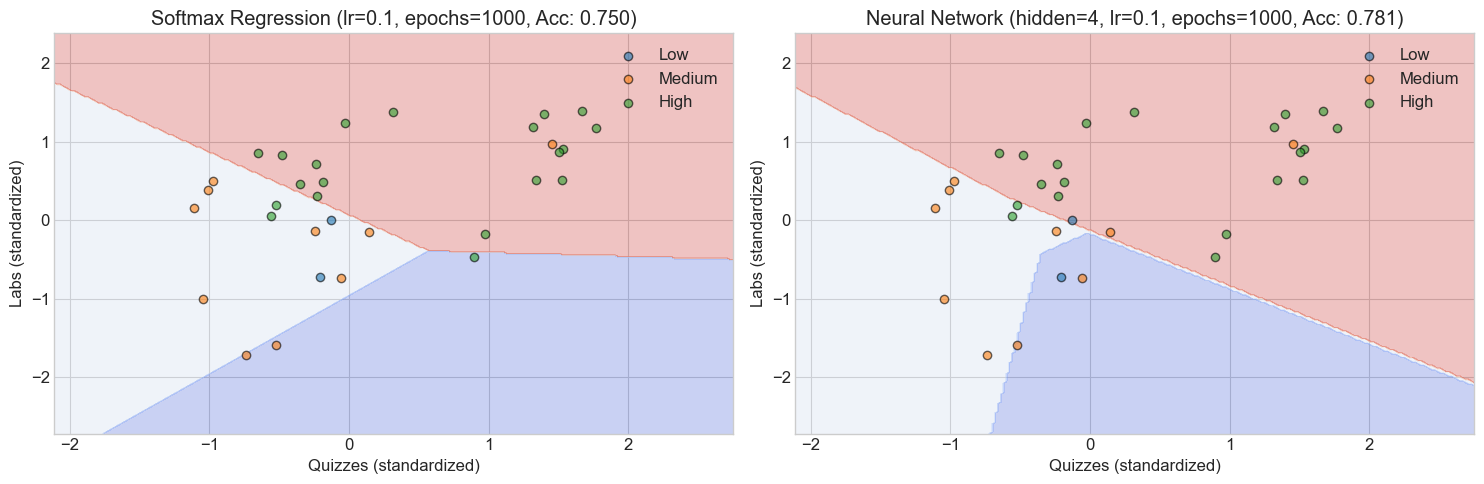

In [15]:

# Define the Neural Network class 
class NeuralNetwork:
    def __init__(self, hidden_size=4, learning_rate=0.1, epochs=1000):
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # We have two sets of weights and biases:
        # 1. From input to hidden layer
        # 2. From hidden layer to output
        self.weights1 = None  # Input -> Hidden
        self.bias1 = None
        self.weights2 = None  # Hidden -> Output
        self.bias2 = None
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1.0, 0.0)
    
    def softmax(self, z):
        # For numerical stability, subtract the maximum value
        shifted_z = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(shifted_z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_classes = len(np.unique(y))
        
        # Initialize weights and biases
        # Input -> Hidden
        self.weights1 = np.random.randn(n_features, self.hidden_size) * 0.01
        self.bias1 = np.zeros((1, self.hidden_size))
        
        # Hidden -> Output
        self.weights2 = np.random.randn(self.hidden_size, self.n_classes) * 0.01
        self.bias2 = np.zeros((1, self.n_classes))
        
        # One-hot encode the target
        y_one_hot = np.zeros((n_samples, self.n_classes))
        y_one_hot[np.arange(n_samples), y] = 1
        
        # Training loop
        for _ in range(self.epochs):
            # Forward pass
            # Input -> Hidden
            hidden_input = np.dot(X, self.weights1) + self.bias1
            hidden_output = self.relu(hidden_input)
            
            # Hidden -> Output
            output_input = np.dot(hidden_output, self.weights2) + self.bias2
            output_probs = self.softmax(output_input)
            
            # Backward pass (backpropagation)
            # Output layer gradients
            d_output = output_probs - y_one_hot
            
            # Hidden layer gradients
            d_weights2 = (1/n_samples) * np.dot(hidden_output.T, d_output)
            d_bias2 = (1/n_samples) * np.sum(d_output, axis=0, keepdims=True)
            
            d_hidden = np.dot(d_output, self.weights2.T) * self.relu_derivative(hidden_input)
            d_weights1 = (1/n_samples) * np.dot(X.T, d_hidden)
            d_bias1 = (1/n_samples) * np.sum(d_hidden, axis=0, keepdims=True)
            
            # Update parameters
            self.weights2 -= self.learning_rate * d_weights2
            self.bias2 -= self.learning_rate * d_bias2
            self.weights1 -= self.learning_rate * d_weights1
            self.bias1 -= self.learning_rate * d_bias1
    
    def forward(self, X):
        # Input -> Hidden
        hidden_input = np.dot(X, self.weights1) + self.bias1
        hidden_output = self.relu(hidden_input)
        
        # Hidden -> Output
        output_input = np.dot(hidden_output, self.weights2) + self.bias2
        output_probs = self.softmax(output_input)
        
        return hidden_output, output_probs
    
    def predict_proba(self, X):
        _, output_probs = self.forward(X)
        return output_probs
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# Train both models
softmax_params = {"learning_rate": 0.1, "epochs": 1000}
nn_params = {"hidden_size": 4, "learning_rate": 0.1, "epochs": 1000}

print(f"Training Softmax Regression with learning_rate={softmax_params['learning_rate']}, epochs={softmax_params['epochs']}...")
softmax_model = SoftmaxRegression(**softmax_params)
softmax_model.fit(X_train_scaled, y_train)

print(f"Training Neural Network with hidden_size={nn_params['hidden_size']}, learning_rate={nn_params['learning_rate']}, epochs={nn_params['epochs']}...")
nn_model = NeuralNetwork(**nn_params)
nn_model.fit(X_train_scaled, y_train)

# Evaluate both models
softmax_preds = softmax_model.predict(X_test_scaled)
nn_preds = nn_model.predict(X_test_scaled)

softmax_accuracy = accuracy_score(y_test, softmax_preds)
nn_accuracy = accuracy_score(y_test, nn_preds)

print(f"Softmax Regression Accuracy: {softmax_accuracy:.4f}")
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")

# Visualize the decision boundaries
def plot_decision_boundaries(models, X, y, titles):
    # Set up the meshgrid
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create figure
    fig, axs = plt.subplots(1, len(models), figsize=(15, 5))
    
    for idx, (model, title) in enumerate(zip(models, titles)):
        # Predict class for each point in the meshgrid
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        axs[idx].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        
        # Plot data points
        for i, label in enumerate(np.unique(y)):
            mask = (y == label)
            axs[idx].scatter(
                X[mask, 0], 
                X[mask, 1], 
                label=grade_labels[i],
                edgecolors='k', 
                alpha=0.6
            )
        
        axs[idx].set_title(title)
        axs[idx].set_xlabel('Quizzes (standardized)')
        axs[idx].set_ylabel('Labs (standardized)')
        axs[idx].legend()
    
    plt.tight_layout()
    plt.show()

# Create dynamic titles that reflect the actual parameters used
softmax_title = f'Softmax Regression (lr={softmax_params["learning_rate"]}, epochs={softmax_params["epochs"]}, Acc: {softmax_accuracy:.3f})'
nn_title = f'Neural Network (hidden={nn_params["hidden_size"]}, lr={nn_params["learning_rate"]}, epochs={nn_params["epochs"]}, Acc: {nn_accuracy:.3f})'

# Plot decision boundaries
plot_decision_boundaries(
    [softmax_model, nn_model], 
    X_test_scaled, 
    y_test, 
    [softmax_title, nn_title]
)

Notice the decision boundaries (change of color): for softmax regression, they are linear. This limits the expressivity or flexibility of the model. The reason for linear decision boundary is because of the linear predictor in the softmax (same for logistic regression).

The neural networks' decision boundary is nonlinear. This is because of the activation functions in each layer and neuron. This makes the model more flexible or expressive / adaptable to the data.

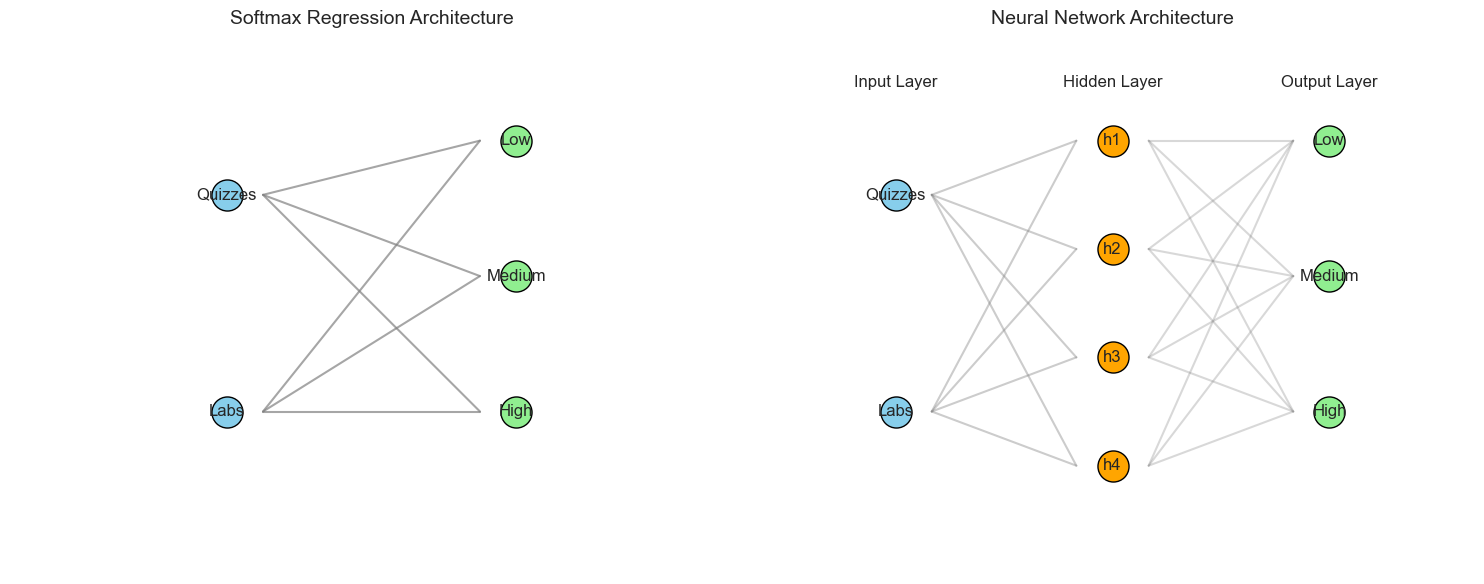

In [17]:
# Visualize the model architectures. Note: the number of hidden units will not change automatically, when it is changed in the code above.
def plot_model_architectures():
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Softmax Regression architecture
    axs[0].set_xlim(0, 10)
    axs[0].set_ylim(0, 10)
    axs[0].axis('off')
    axs[0].set_title('Softmax Regression Architecture', fontsize=14)
    
    # Draw input nodes
    axs[0].scatter([3, 3], [7, 3], s=500, color='skyblue', edgecolor='black')
    axs[0].text(3, 7, 'Quizzes', ha='center', va='center')
    axs[0].text(3, 3, 'Labs', ha='center', va='center')
    
    # Draw output nodes
    for i, label in enumerate(grade_labels):
        y_pos = 8 - i * 2.5
        axs[0].scatter(7, y_pos, s=500, color='lightgreen', edgecolor='black')
        axs[0].text(7, y_pos, label, ha='center', va='center')
    
    # Draw connections
    for i, _ in enumerate(grade_labels):
        y_pos = 8 - i * 2.5
        axs[0].plot([3.5, 6.5], [7, y_pos], 'gray', alpha=0.7)
        axs[0].plot([3.5, 6.5], [3, y_pos], 'gray', alpha=0.7)
    
    # Neural Network architecture
    axs[1].set_xlim(0, 10)
    axs[1].set_ylim(0, 10)
    axs[1].axis('off')
    axs[1].set_title('Neural Network Architecture', fontsize=14)
    
    # Draw input nodes
    axs[1].scatter([2, 2], [7, 3], s=500, color='skyblue', edgecolor='black')
    axs[1].text(2, 7, 'Quizzes', ha='center', va='center')
    axs[1].text(2, 3, 'Labs', ha='center', va='center')
    
    # Draw hidden nodes
    hidden_y = [8, 6, 4, 2]
    for y_pos in hidden_y:
        axs[1].scatter(5, y_pos, s=500, color='orange', edgecolor='black')
        axs[1].text(5, y_pos, f'h{hidden_y.index(y_pos)+1}', ha='center', va='center')
    
    # Draw output nodes
    for i, label in enumerate(grade_labels):
        y_pos = 8 - i * 2.5
        axs[1].scatter(8, y_pos, s=500, color='lightgreen', edgecolor='black')
        axs[1].text(8, y_pos, label, ha='center', va='center')
    
    # Draw connections (input to hidden)
    for h_y in hidden_y:
        axs[1].plot([2.5, 4.5], [7, h_y], 'gray', alpha=0.4)
        axs[1].plot([2.5, 4.5], [3, h_y], 'gray', alpha=0.4)
    
    # Draw connections (hidden to output)
    for h_y in hidden_y:
        for i, _ in enumerate(grade_labels):
            y_pos = 8 - i * 2.5
            axs[1].plot([5.5, 7.5], [h_y, y_pos], 'gray', alpha=0.3)
    
    # Add labels for layers
    axs[1].text(2, 9, 'Input Layer', ha='center', fontsize=12)
    axs[1].text(5, 9, 'Hidden Layer', ha='center', fontsize=12)
    axs[1].text(8, 9, 'Output Layer', ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Plot the model architectures
plot_model_architectures()